In [64]:
import numpy as np
from utils.dataloader import ClsDatasets
from utils.utils import get_classes

# 1.获取类别和数量

In [2]:
classes_path = '../path_txt/cls_classes.txt'
class_names, num_classes = get_classes(classes_path) #得到类别与种类个数

In [3]:
print(class_names, num_classes)

['Retinopathy_grade_0', 'Retinopathy_grade_1', 'Retinopathy_grade_2', 'Retinopathy_grade_3'] 4


# 2.获取训练集和验证集

In [4]:
annotation_path = "../path_txt/test_stable/train_val.txt"
val_split       = 0.2

with open(annotation_path, "r") as f:
    lines = f.readlines()

In [5]:
len(lines)

3338

In [6]:
#不划分训练集和验证集时，做K折交叉验证
train_val_path = lines
np.random.seed(10101)
np.random.shuffle(train_val_path)
np.random.seed(None)

In [7]:
#测试集路径

In [8]:
annotation_path = "../path_txt/test_stable/test.txt"

with open(annotation_path, "r") as f:
    test_path = f.readlines()

In [9]:
#得到 train_path val_path  

# 3.得到训练和验证的数据

In [10]:
train_val_dataloader    = ClsDatasets(train_val_path, [224, 224], 1, num_classes, train = True)

In [11]:
#train_val_dataloader[0]

In [12]:
X_train_val = []
Y_train_val =[]

for x,y in train_val_dataloader:
    X_train_val.append(x)
    Y_train_val.append(y)

X_train_val = np.asarray(X_train_val)
Y_train_val = np.asarray(Y_train_val)

X_train_val = np.squeeze(X_train_val, 1)
Y_train_val = np.squeeze(Y_train_val, 1)

Y_train_val = np.argmax(Y_train_val,axis=1)

In [13]:
X_train_val.shape

(3338, 224, 224, 3)

# 4.特征提取用Resnet101

In [14]:
from tensorflow.keras.layers import (Input,GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras import applications

In [15]:
def resnet101(input_shape=None):
    net = applications.ResNet101(include_top=False,input_shape=input_shape,weights=None)
    return net

def Feature_Extraction(input_shape=[224,224,3]):
    img_input = Input(input_shape)
    x = resnet101(input_shape)(img_input)
    x = GlobalAveragePooling2D()(x)
    x = Model(img_input, x, name='ResNet101')
    return x

In [16]:
extra_model = Feature_Extraction(input_shape=[224,224,3])

In [17]:
extra_model.load_weights("extra_model_weight.h5")

In [18]:
#特征提取后的
X_train_val_extra = extra_model.predict(X_train_val)

In [19]:
X_train_val_extra.shape

(3338, 2048)

# 5.分类模型

In [20]:
from sklearn.model_selection import cross_val_score 
#from sklearn.model_selection import train_test_split

# 网格搜索K值

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

parameters={'n_neighbors':[3,4,5,10,15,20,40,50,70]}
model2 = KNeighborsClassifier()
cvModel=GridSearchCV(model2,parameters,cv=10,scoring='accuracy')
cvModel.fit(X_train_val_extra,Y_train_val)
#print(cvModel.best_score_)
#print(cvModel.best_params_)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 10, 15, 20, 40, 50, 70]},
             scoring='accuracy')

In [24]:
cvModel.cv_results_

{'mean_fit_time': array([0.01700304, 0.01786177, 0.01664345, 0.01689293, 0.01687367,
        0.01850405, 0.0180485 , 0.0173739 , 0.01687636]),
 'std_fit_time': array([0.00321989, 0.00321528, 0.00343824, 0.00298102, 0.0025068 ,
        0.00354851, 0.00342984, 0.00432839, 0.00213199]),
 'mean_score_time': array([0.12074914, 0.1204246 , 0.12064211, 0.11950874, 0.1234113 ,
        0.12313206, 0.11944976, 0.12312682, 0.12377028]),
 'std_score_time': array([0.00777644, 0.00150032, 0.00432411, 0.00381687, 0.00317997,
        0.00999212, 0.00299453, 0.00487605, 0.00429232]),
 'param_n_neighbors': masked_array(data=[3, 4, 5, 10, 15, 20, 40, 50, 70],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_neighbors': 20},
  {'n_neighbors': 40},
  {'n_neighbors': 50},
  {'

In [25]:
cvModel.best_params_

{'n_neighbors': 20}

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# 建立Knn模型
knn = KNeighborsClassifier(n_neighbors=4)

# 使用K折交叉验证模块
scores = cross_val_score(knn, X_train_val_extra, Y_train_val, cv=10, scoring='accuracy')

# 将5次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.8742515  0.91616766 0.91317365 0.88323353 0.90419162 0.89221557
 0.92215569 0.91017964 0.9009009  0.92192192]
0.903839168509827


### KNN模型

In [20]:
from sklearn.neighbors import KNeighborsClassifier
# 建立Knn模型
knn = KNeighborsClassifier(n_neighbors=4)

# 使用K折交叉验证模块
scores = cross_val_score(knn, X_train_val_extra, Y_train_val, cv=10, scoring='accuracy')

# 将5次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.89221557 0.88023952 0.91017964 0.91017964 0.91017964 0.9011976
 0.91317365 0.89820359 0.93993994 0.90990991]
0.9065418712125298


### 上面是测试，最后用K=20

In [66]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn_model = knn.fit(X_train_val_extra,Y_train_val)

In [67]:
from sklearn.metrics import precision_score,recall_score,f1_score

#x_val_for_test

#accuracy = modelbagging.score(X_test,y_test)  Y_actual_val, Y_pred_val
Y_pred_val = knn_model.predict(x_val_for_test)
accuracy = knn_model.score(x_val_for_test, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='weighted')
recall = recall_score(Y_actual_val, Y_pred_val, average='weighted')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')
#acu_data = modelbagging.score(X_fsvar,y)
#acu_correct = modelbagging.score(X_correct,y_correct)

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1  * 100))
#print('AUC Score: {:.2f}%'.format(auc_score * 100))
#print('原数据集所有样本的准确率:{:.2f}%'.format(acu_data * 100))
#print('正样本的准确率:{:.2f}%'.format(acu_correct * 100))


Accuracy: 86.54%
Precision: 86.75%
Recall: 86.54%
F1: 86.58%


### 朴素贝叶斯算法

### 支持向量机

### 没有调参的结果

In [26]:
from sklearn.svm import SVC

### 数据太多，降下维

In [21]:
from sklearn.decomposition import PCA

In [41]:
# pca = PCA(n_components='mle')
# X_train_val_extra_pca = pca.fit_transform(X_train_val_extra)
# print(pca.n_features_)
# print(pca.n_samples_)
# print(pca.explained_variance_ratio_)

In [60]:
svc_cls = SVC()

# 使用K折交叉验证模块
scores = cross_val_score(svc_cls, X_train_val_extra, Y_train_val, cv=10, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.93113772 0.93113772 0.92814371 0.9491018  0.92814371 0.92814371
 0.93712575 0.9251497  0.94294294 0.94594595]
0.9346972721224219


In [62]:
svc_cls = SVC()
svc_cls.fit(X_train_val_extra,Y_train_val)

SVC()

In [63]:
from sklearn.metrics import precision_score,recall_score,f1_score

Y_pred_val = svc_cls.predict(x_val_for_test)
accuracy = svc_cls.score(x_val_for_test, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='macro')
recall = recall_score(Y_actual_val, Y_pred_val, average='micro')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 85.94%
Precision: 85.98%
Recall: 85.94%
F1: 85.95%


### 网格搜索支持向量机的参数

In [27]:
from sklearn.model_selection import GridSearchCV
parameters={'kernel':['linear','rbf'],'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}
svc = SVC()
svc_grid = GridSearchCV(svc,parameters,cv=5,scoring='accuracy')
svc_grid.fit(X_train_val_extra,Y_train_val)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [28]:
print(svc_grid.best_params_)
print(svc_grid.best_score_)

{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
0.935894926788103


In [29]:
svc_cls = SVC(C=0.01, gamma=0.001, kernel='linear')
svc_cls.fit(X_train_val_extra,Y_train_val)

SVC(C=0.01, gamma=0.001, kernel='linear')

In [71]:
from sklearn.metrics import precision_score,recall_score,f1_score

Y_pred_val = svc_cls.predict(x_val_for_test)
accuracy = svc_cls.score(x_val_for_test, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='weighted')
recall = recall_score(Y_actual_val, Y_pred_val, average='weighted')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 87.02%
Precision: 87.24%
Recall: 87.02%
F1: 87.06%


### 随机森林

### 没有调参的结果

In [30]:
from sklearn.ensemble import RandomForestClassifier#调用随机森林模型

In [32]:
RF_cls = RandomForestClassifier()

# 使用K折交叉验证模块
scores = cross_val_score(RF_cls, X_train_val_extra, Y_train_val, cv=10, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.90718563 0.91017964 0.92215569 0.92215569 0.89520958 0.92215569
 0.92814371 0.91916168 0.92792793 0.92492492]
0.9179200158242076


In [33]:
RF_cls = RandomForestClassifier()
RF_cls.fit(X_train_val_extra,Y_train_val)

RandomForestClassifier()

In [34]:
from sklearn.metrics import precision_score,recall_score,f1_score

Y_pred_val = RF_cls.predict(x_val_for_test)
accuracy = RF_cls.score(x_val_for_test, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='macro')
recall = recall_score(Y_actual_val, Y_pred_val, average='micro')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 86.42%
Precision: 86.80%
Recall: 86.42%
F1: 86.44%


### 网格搜索随机森林参数

In [35]:
from sklearn.model_selection import GridSearchCV

In [38]:
#首先对n_estimators进行网格搜索  
param_test1= {'n_estimators':range(100,241,20)}  
gsearch1= GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,  
                                                            min_samples_leaf=20,max_depth=8,max_features='sqrt',),  
                                                            param_grid = param_test1, scoring='accuracy',cv=10)  
gsearch1.fit(X_train_val_extra,Y_train_val)  

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=8, max_features='sqrt',
                                              min_samples_leaf=20,
                                              min_samples_split=100),
             param_grid={'n_estimators': range(100, 241, 20)},
             scoring='accuracy')

In [39]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'n_estimators': 160}
0.9086340831849814


In [40]:
#最大深度max_depth和内部节点再划分所需最小样本数min_samples_split进行网格搜索。
param_test2= {'max_depth':range(3,14,2), 'min_samples_split':range(50,201,20)}  
gsearch2= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 160,  
                                                             min_samples_leaf=20,max_features='sqrt'),  
                                                             param_grid = param_test2,scoring='accuracy',cv=10)
gsearch2.fit(X_train_val_extra,Y_train_val)  


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              min_samples_leaf=20,
                                              n_estimators=160),
             param_grid={'max_depth': range(3, 14, 2),
                         'min_samples_split': range(50, 201, 20)},
             scoring='accuracy')

In [41]:
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'max_depth': 11, 'min_samples_split': 50}
0.9113286939634246


In [42]:
#再对内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf一起调参 
param_test3= {'min_samples_split':range(80,150,20), 'min_samples_leaf':range(10,60,10)}  
gsearch3= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 160,max_depth=11,  
                                   max_features='sqrt'),  
                                   param_grid = param_test3,scoring='accuracy', cv=10)  

In [43]:
gsearch3.fit(X_train_val_extra,Y_train_val)  

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=11, max_features='sqrt',
                                              n_estimators=160),
             param_grid={'min_samples_leaf': range(10, 60, 10),
                         'min_samples_split': range(80, 150, 20)},
             scoring='accuracy')

In [44]:
print(gsearch3.best_params_)
print(gsearch3.best_score_)

{'min_samples_leaf': 10, 'min_samples_split': 80}
0.9095304885724047


### 搜索出的参数代入

In [45]:
RF_cls = RandomForestClassifier(n_estimators= 160, max_depth=11, max_features='sqrt', min_samples_leaf=10, min_samples_split=80)

# 使用K折交叉验证模块
scores = cross_val_score(RF_cls, X_train_val_extra, Y_train_val, cv=10, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.89820359 0.88922156 0.92215569 0.9251497  0.89520958 0.90718563
 0.90718563 0.91317365 0.89489489 0.92192192]
0.9074301846756937


In [57]:
RF_cls = RandomForestClassifier(n_estimators= 160, max_depth=11, max_features='sqrt', min_samples_leaf=10, min_samples_split=40)
RF_cls.fit(X_train_val_extra,Y_train_val)

RandomForestClassifier(max_depth=11, max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=40, n_estimators=160)

In [58]:
from sklearn.metrics import precision_score,recall_score,f1_score

Y_pred_val = RF_cls.predict(x_val_for_test)
accuracy = RF_cls.score(x_val_for_test, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='macro')
recall = recall_score(Y_actual_val, Y_pred_val, average='micro')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 85.34%
Precision: 85.98%
Recall: 85.34%
F1: 85.35%


### 支持向量机加随机森林 voting

In [51]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier#调用随机森林模型
from sklearn.ensemble import VotingClassifier

In [60]:
clf1 = RandomForestClassifier(n_estimators= 160, max_depth=11, max_features='sqrt', min_samples_leaf=10, min_samples_split=40)
clf2 = SVC(C=0.01, gamma=0.001, kernel='linear',probability=True)

clf_vot = VotingClassifier(estimators=[('RF', clf1), ('svm', clf2)],voting='soft')

In [61]:
# 使用K折交叉验证模块
scores = cross_val_score(clf_vot, X_train_val_extra, Y_train_val, cv=10, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.92814371 0.91616766 0.9251497  0.93113772 0.94610778 0.92814371
 0.94311377 0.93712575 0.93093093 0.96096096]
0.9346981712251173


In [62]:
clf_vot.fit(X_train_val_extra, Y_train_val)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(max_depth=11,
                                                     max_features='sqrt',
                                                     min_samples_leaf=10,
                                                     min_samples_split=40,
                                                     n_estimators=160)),
                             ('svm',
                              SVC(C=0.01, gamma=0.001, kernel='linear',
                                  probability=True))],
                 voting='soft')

In [63]:
from sklearn.metrics import precision_score,recall_score,f1_score

Y_pred_val = clf_vot.predict(x_val_for_test)
accuracy = clf_vot.score(x_val_for_test, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='macro')
recall = recall_score(Y_actual_val, Y_pred_val, average='micro')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 87.26%
Precision: 87.24%
Recall: 87.26%
F1: 87.30%


### 集成学习

### Adaboost

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [32]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=11, min_samples_leaf=10, min_samples_split=40))

In [33]:
# 使用K折交叉验证模块
scores = cross_val_score(clf, X_train_val_extra, Y_train_val, cv=10, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.90718563 0.89520958 0.9251497  0.92215569 0.91017964 0.90718563
 0.91916168 0.91317365 0.92492492 0.91291291]
0.9137239035442629


In [34]:
clf.fit(X_train_val_extra, Y_train_val)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=11,
                                                         min_samples_leaf=10,
                                                         min_samples_split=40))

In [35]:
from sklearn.metrics import precision_score,recall_score,f1_score

Y_pred_val = clf.predict(x_val_for_test)
accuracy = clf.score(x_val_for_test, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='macro')
recall = recall_score(Y_actual_val, Y_pred_val, average='micro')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 85.10%
Precision: 85.80%
Recall: 85.10%
F1: 85.15%


### GradientBoost

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

In [37]:
clf_grd = GradientBoostingClassifier(max_depth=11, max_features='sqrt', min_samples_leaf=10,
                                   min_samples_split=40, n_estimators=160, learning_rate=0.05, subsample=0.95)

In [38]:
# 使用K折交叉验证模块
scores = cross_val_score(clf_grd, X_train_val_extra, Y_train_val, cv=10, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.9251497  0.91317365 0.94011976 0.93113772 0.93113772 0.91616766
 0.94011976 0.93413174 0.93693694 0.94594595]
0.9314020607433781


In [39]:
clf_grd.fit(X_train_val_extra, Y_train_val)

GradientBoostingClassifier(learning_rate=0.05, max_depth=11,
                           max_features='sqrt', min_samples_leaf=10,
                           min_samples_split=40, n_estimators=160,
                           subsample=0.95)

In [40]:
from sklearn.metrics import precision_score,recall_score,f1_score

Y_pred_val = clf_grd.predict(x_val_for_test)
accuracy = clf_grd.score(x_val_for_test, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='macro')
recall = recall_score(Y_actual_val, Y_pred_val, average='micro')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 87.62%
Precision: 87.75%
Recall: 87.62%
F1: 87.63%


### xgboost

In [43]:
#!pip install xgboost

In [44]:
import xgboost as xgb

In [45]:
clf_xgb = xgb.XGBClassifier()

In [46]:
# 使用K折交叉验证模块
scores = cross_val_score(clf_xgb, X_train_val_extra, Y_train_val, cv=10, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.92215569 0.91916168 0.93113772 0.92215569 0.92814371 0.92814371
 0.9251497  0.93413174 0.93993994 0.94294294]
0.9293062523601447


In [48]:
clf_xgb.fit(X_train_val_extra, Y_train_val)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [49]:
from sklearn.metrics import precision_score,recall_score,f1_score

Y_pred_val = clf_xgb.predict(x_val_for_test)
accuracy = clf_xgb.score(x_val_for_test, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='macro')
recall = recall_score(Y_actual_val, Y_pred_val, average='micro')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 86.54%
Precision: 86.59%
Recall: 86.54%
F1: 86.58%


# 6.用测试集来画混淆矩阵

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt
%matplotlib inline

# borrowed from scikit learn  这个是为了画混淆矩阵
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [23]:
len(test_path)

832

In [24]:
val_for_test = ClsDatasets(test_path, [224,224], 1, num_classes, train = False)

x_val_for_test = []
y_val_for_test =[]

for x,y in val_for_test:
    x_val_for_test.append(x)
    y_val_for_test.append(y)

x_val_for_test = np.asarray(x_val_for_test)
y_val_for_test = np.asarray(y_val_for_test)

x_val_for_test = np.squeeze(x_val_for_test, 1)
y_val_for_test = np.squeeze(y_val_for_test, 1)

x_val_for_test = extra_model.predict(x_val_for_test)  #测试集特征提取后的结果
Y_actual_val = np.argmax(y_val_for_test,axis=1)   #测试集真实的标签

In [ ]:
#y_val_for_test_pred = knn_model.predict(x_val_for_test)  #KNN
y_val_for_test_pred = RM_cls.predict(x_val_for_test)      #随机森林

Y_pred_val = y_val_for_test_pred  #np.argmax(y_val_for_test_pred,axis=1)

Confusion matrix, without normalization
[[227  12  21   2]
 [ 22 133  14   2]
 [ 15   3 169   9]
 [  3   0  11 189]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

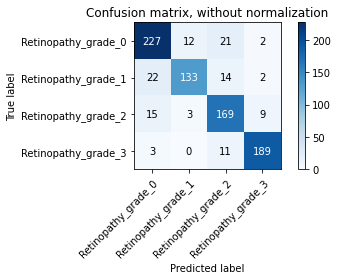

In [28]:
plot_confusion_matrix(Y_actual_val, Y_pred_val, np.array(class_names))